# Wind Turbine Power Production
___

###  Project assessment
#### [Fundamentals of Data Analysis Module GMIT 2020 ]

<br>

<img align="left" width="300" src="https://www.pinclipart.com/picdir/big/153-1532157_wind-turbine-icon-on-green-background-wind-turbine.png">
<br>

<br>

Lecturer: _[Ian McLoughlin](https://github.com/ianmcloughlin)_

Completed by: *Olga Rozhdestvina (G00387844@gmit.ie)*

---

## Table of Contents

* [Overview](#overview)
* [General Setup](#setup)
* [Reading the Data and Performing Basic Data Checks](#loading_data)
* [Data Preprocessing](#preproccesing)
    * [Removing Outliers](#outliers)
    * [Creating Arrays for the Speed and the Power Variables](#arrays)
    * [Scaling](#scale)
    * [Creating the Training and Test Data sets](#split)
* [Build, Predict, and Evaluate the Models with NumPy](#numpy)
* [Build, Predict, and Evaluate the Models with SciPy](#scipy)

<br>

### Overview. <a name="overview"></a>
___

Wind turbine power output is known for having a strong correlation with wind speed. In this work, **simple linear regression** was built for predicting the turbine response for a given wind speed. For comparison, **polynomial regression** was applied to the same data set. Since a similar work was completed in my project assessment for [Machine Learning and Statistics model](https://github.com/olgarozhdestvina/Machine-Learning-and-Statistics-Project/blob/main/Power_production_models.ipynb) using Scikit-learn and Tensorflow Keras, this project is completed using:

* a method from [NumPy](https://numpy.org/) package that performs least squares fit to data. [1]
* a function from [SciPy](https://www.scipy.org/) that uses non-linear least squares to fit a function f to data. [2]
* a SciPy function for building a general polynomial model.[3]


The notebook also includes an analysis of a data set **powerproduction** and its preprocessing. 

The performance evaluation of the models was conducted using two metrics - R-squared regression score [4] and Root Mean Squared Error (RMSE) [5]. The indicators of a good model are low RMSE and high R-squared regression score.

> [1] [numpy.polynomial.polynomial.Polynomial.fit](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.Polynomial.fit.html)
<br>
[2] [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)
<br>
[3] [scipy.odr.polynomial](https://docs.scipy.org/doc/scipy/reference/generated/scipy.odr.polynomial.html)
<br>
[4] [How to calculate R squared with NumPy in Python]( https://www.kite.com/python/answers/how-to-calculate-r-squared-with-numpy-in-python)
<br>
[5] [How to calculate RMSE using IPython/NumPy?](https://stackoverflow.com/questions/21926020/how-to-calculate-rmse-using-ipython-numpy)




<br>

### General Setup. <a name="setup"></a>
___

In [1]:
# Numerical arrays.
import numpy as np

# Models.
from numpy.polynomial.polynomial import Polynomial as poly
from scipy.optimize import curve_fit
from scipy import odr

# Data frames.
import pandas as pd

from scipy import stats
# Plotting.
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Style for plots.
plt.style.use('ggplot')
plt.rcParams["figure.titlesize"] = 18

# Plot size.
plt.rcParams['figure.figsize'] = [14, 8]

<br>

### Reading the Data and Performing Basic Data Checks. <a name="loading_data"></a>
___


In [3]:
# Load the data set.
df = pd.read_csv("powerproduction.txt")

# Display the data frame.
df

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


The data set has 500 rows and 2 columns with two numerical variables, **speed** and **power**, which are represented by real numbers. There are no empty values in the data set.

In [4]:
# Generate descriptive statistics.
df.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


The mean speed is 12.59, while the mean power stands at 48.01. Moreover, there is a difference in the scale of the variables: speed has a range between 0.00 to 25.00 and power - between 0.00 and 113.556. This difference will be addressed in the preprocessing.

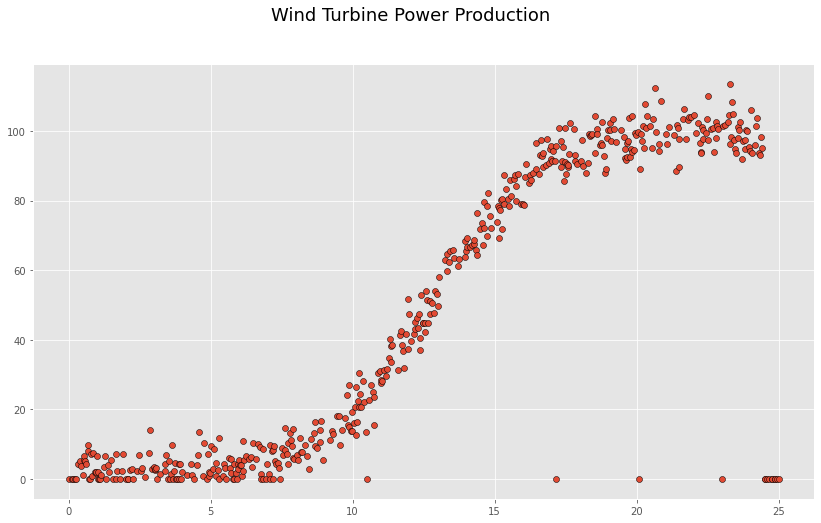

In [5]:
# Create a figure. axis and title.
fig,ax = plt.subplots()
fig.suptitle("Wind Turbine Power Production")

# Plot the data.
ax.scatter(df.speed, df.power,edgecolor="black")

# Show the plot.
plt.show()

The above plot shows that the relationship between Power and Speed predominantly takes an "S"-shape. The power rises dramatically with speed over about 8 m/s and slows when the speed reaches about 17 m/s.

Additionally, we can see some outliers where the speed is approximately between 5 m/s and 24 m/s. However, the power is still 0. The 0 power points for around 25 m/s wind speed might be suggestting the shutdown of the wind turbine for damage mitigation, thus I will not consider them as outliners.

<br>

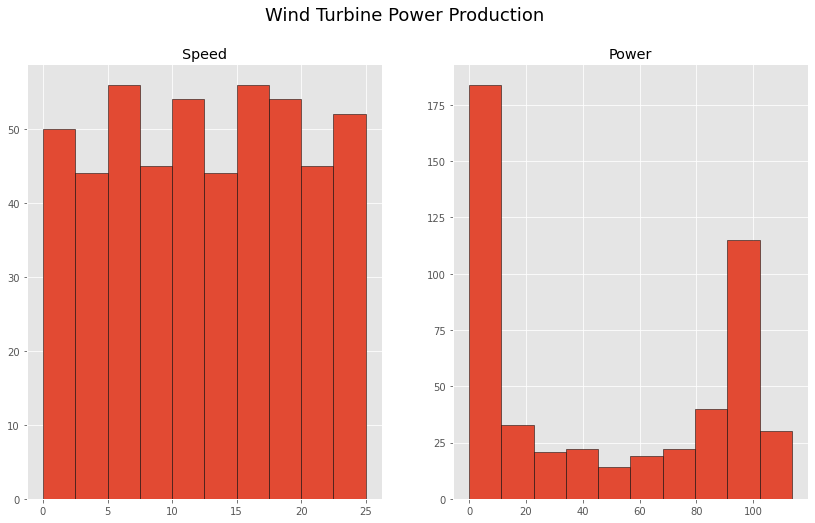

In [6]:
# Create a figure, axis 1x2 and titles
fig, [ax1,ax2] = plt.subplots(1,2)
fig.suptitle("Wind Turbine Power Production")
ax1.set_title("Speed")
ax2.set_title("Power")

# Plot data.
ax1.hist(df.speed, edgecolor="black")
ax2.hist(df.power, edgecolor="black")

# Show the plots.
plt.show()

<br>

The data does not appear to attain normal distribution and it is difficult to say which type of distribution will fit any of the variables with any degree of certainty.

<br>

###  Data Preprocessing. <a name="preproccesing"></a>
___

Prior to building models the data should undergo data preprocessing. 

There are 4 steps:
* Removing Outliers
* Creating arrays for the speed and the power.
* Scaling to account for the difference in scale of the variables.
* Creating the training and test data sets.

#### 1. Removing Outliers.  <a name="outliers"></a>
The first step is to remove the outliers from our data set. [6]

> [6] [Delete rows based on multiple conditions; including other column conditionals](https://stackoverflow.com/questions/31997992/delete-rows-based-on-multiple-conditions-including-other-column-conditionals)

In [7]:
# Remove Outliers.
df_new = df.drop(df[(df.power == 0) & (df.speed > 5) & (df.speed < 24)].index)

# Display the cleaned data set.
df_new

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


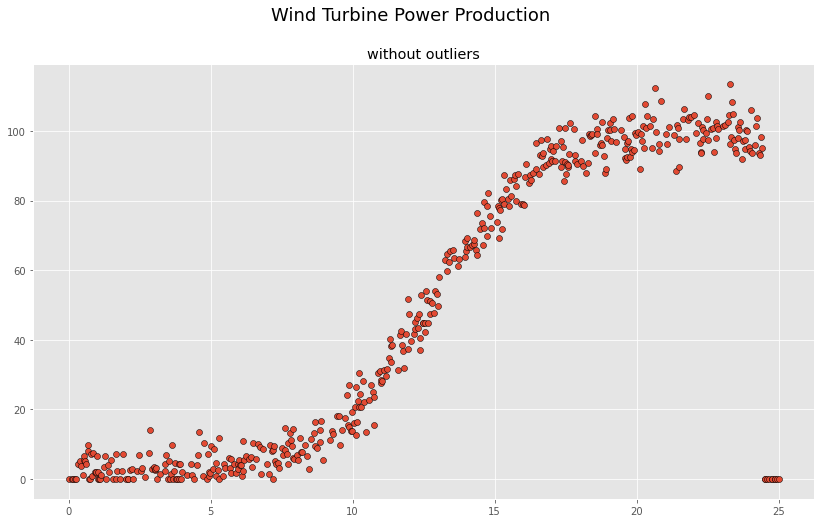

In [8]:
# Create a figure. axis and title.
fig,ax = plt.subplots()
fig.suptitle("Wind Turbine Power Production")
ax.set_title("without outliers")

# Plot the data.
ax.scatter(df_new.speed, df_new.power,edgecolor="black")

# Show the plot.
plt.show()

<br>

#### 2. Creating Arrays for the Speed and the Power Variables.  <a name="arrays"></a>

Now the data set should be separated for speed and power values. I will also preprocess a few speed samples for 0 m/s, 30 m/s, 70 m/s as it is known from the data set that the power output should be 0. 

In [9]:
# Separate speed and power.
speed = df_new.iloc[:, 0].values
power = df_new.iloc[:, 1].values

# Convert them into a numpy array and reshape.
X = np.array(speed)
y = np.array(power)

<br>

#### 3. Scaling. <a name="scale"></a>
Next we can scale the variables. By comparing different scalers I reached the conclusion that the best results are achieved with MinMaxScaler. [6]

> [6] [Normalization Techniques in Python Using NumPy](https://towardsdatascience.com/normalization-techniques-in-python-using-numpy-b998aa81d754)

In [10]:
# Scale the data.
X_scaled = (X - np.min(X)) / np.ptp(X)
y_scaled = (y - np.min(y)) / np.ptp(y)

# The scaled data set.
df_rescaled = pd.DataFrame({"speed":X_scaled, "power":y_scaled})
df_rescaled

,speed,power
0,0.000,0.0
1,0.005,0.0
2,0.006,0.0
3,0.009,0.0
4,0.011,0.0
...,...,...
482,0.991,0.0
483,0.994,0.0
484,0.995,0.0
485,0.998,0.0


<br>

#### 4. Creating the Training and Test Data sets.  <a name="split"></a>
We will build our model on the training set and evaluate its performance on the test set. [7] [8]

> [7] [Train test split without using scikit learn](https://stackoverflow.com/questions/47202182/train-test-split-without-using-scikit-learn/47202397)
<br>
[8] [pandas.DataFrame.sample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html)

In [11]:
# Shuffle the data set 
shuffle_df = df_rescaled.sample(frac=1, random_state=1)

# Define a size for your train set 
train_size = int(0.7 * len(df_rescaled))

# Split the data on training and test
speed_train, speed_test = shuffle_df.speed[:train_size].values, shuffle_df.speed[train_size:].values
power_train, power_test = shuffle_df.power[:train_size].values, shuffle_df.power[train_size:].values

# Print the shape of the new sets.
print(f"Training set: {speed_train.shape}, {power_train.shape}")
print(f"Test set: {speed_test.shape}, {power_test.shape}")

Training set: (340,), (340,)
Test set: (147,), (147,)


<br>

### Build, Predict, and Evaluate the Models with NumPy  <a name="numpy"></a>
___ 

<br>

#### Simple Linear Regression.  <a name="lr"></a>
___

Hypothesis Function For Simple Linear Regression

$y = beta_0 + beta_1 * x$

<br>

_Model Building._

<br>

In [12]:
# Create a model and fit it.
linear = poly.fit(speed_train, power_train, 1)
linear

Polynomial([0.42812243, 0.55525802], domain=[0., 1.], window=[-1.,  1.])

The above shows that the best fitting line for our data follows the formula

$y = -1.0 + 2.0 * x$

<br>

_Prediction_

Now that we have the model created, we can make predictions on the training and test data and plot them along with the actual data.

In [13]:
# Predict power for the train and test speed.
y_train_linear = linear(speed_train)
y_test_linear = linear(speed_test)

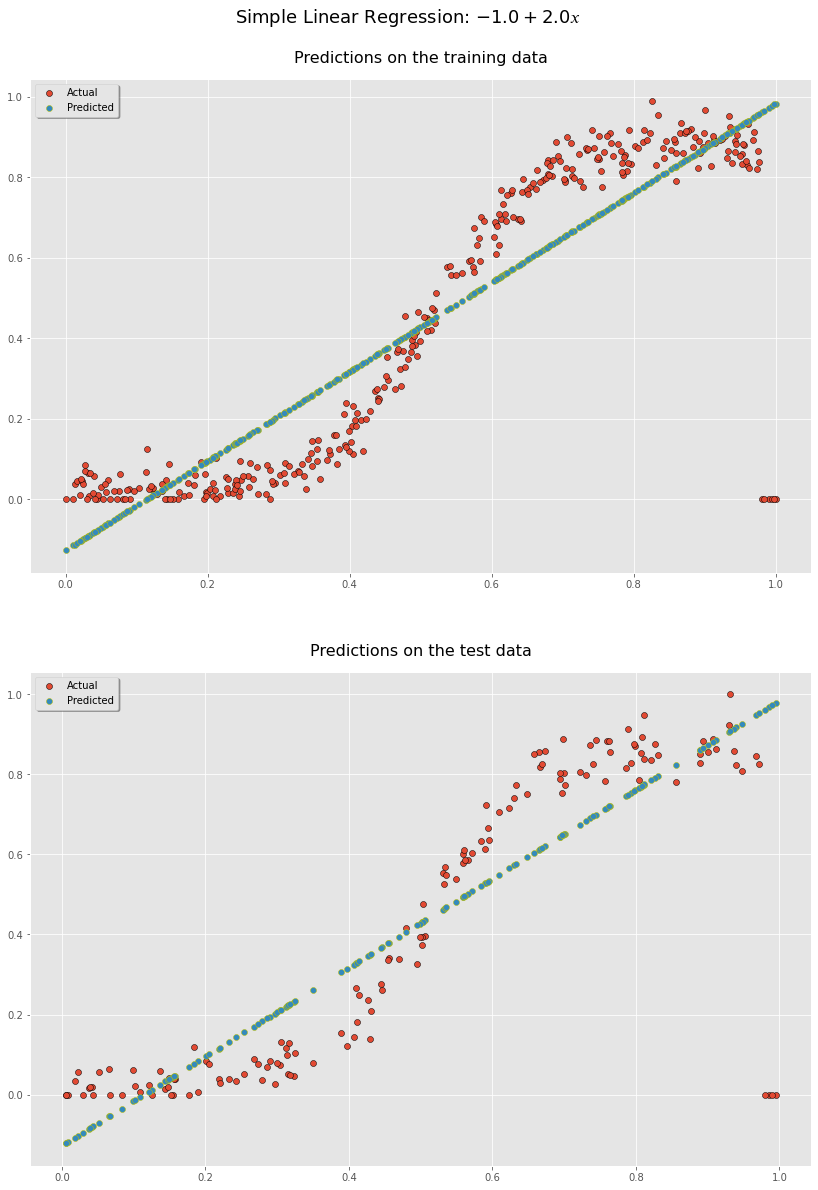

In [14]:
# Plot the actual and predicted data.
def plot(pred_train, pred_test, title):
    # Create a figure, axis and titles.
    fig, [ax1,ax2] = plt.subplots(2,1, figsize=(14,20))
    fig.suptitle(f"{title}", y = 0.93)
    ax1.set_title("Predictions on the training data",y=1.02, fontsize=16)
    ax2.set_title("Predictions on the test data",y=1.02, fontsize=16)

    # Plot the actual training data and predictions.
    ax1.scatter(speed_train, power_train, edgecolor="black",  label="Actual")
    ax1.scatter(speed_train, pred_train, edgecolor="y", label="Predicted")

    # Plot the actual test data and predictions.
    ax2.scatter(speed_test, power_test, edgecolor="black",  label="Actual")
    ax2.scatter(speed_test, pred_test, edgecolor="y", label="Predicted")

    # Show the legend.
    ax1.legend(loc='upper left', shadow=True)
    ax2.legend(loc='upper left', shadow=True)

    # Show the plot.
    plt.show()

# Plot the actual and predicted data for simple linear regression.
plot(y_train_linear, y_test_linear, "Simple Linear Regression: $-1.0+2.0𝑥$")

<br>
It is clear from the the above plots that the simple linear regression underfits our data. Neither does it reflect the downward trend after the speed reaches about 24.4 m/s. Additionally, it predicts negative values and the variables in the original data set are non-negative.

<br>

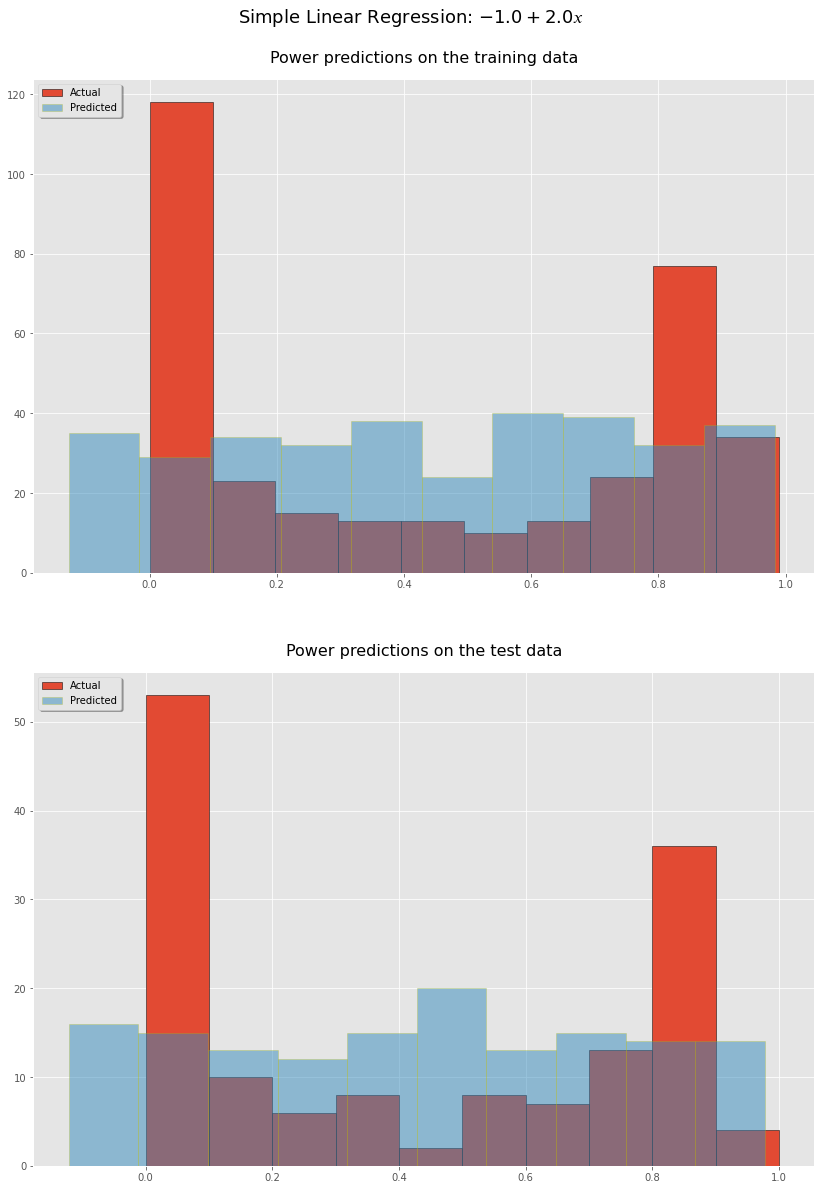

In [15]:
# Histograms to compare the predicted and actual power distribution
def hist(pred_train, pred_test, title):
    # Create a figure, axis and titles.
    fig, [ax1,ax2] = plt.subplots(2,1, figsize=(14,20))
    fig.suptitle(f"{title}", y = 0.93)
    ax1.set_title("Power predictions on the training data",y=1.02, fontsize=16)
    ax2.set_title("Power predictions on the test data",y=1.02, fontsize=16)

    # Plot the actual training data and predictions.
    ax1.hist(power_train, edgecolor="black",  label="Actual")
    ax1.hist(pred_train, edgecolor="y", label="Predicted", alpha=0.5)

    # Plot the actual test data and predictions.
    ax2.hist(power_test, edgecolor="black",  label="Actual")
    ax2.hist(pred_test, edgecolor="y", label="Predicted", alpha=0.5)

    # Show the legend.
    ax1.legend(loc='upper left', shadow=True)
    ax2.legend(loc='upper left', shadow=True)

    # Show the plot.
    plt.show()

# Comparing power distribution for simple linear regression.
hist(y_train_linear, y_test_linear, "Simple Linear Regression: $-1.0+2.0𝑥$")

<br>

The histograms show that the predicted power output is distributed rather diffirently from the original data.

<br>

To view the results the rescaled power needs to be transformed back. To improve the performance of the simple linear regression I will also add two constraints for removing negative and very high predicted values. 

For comparison of the actual and predicted power I randomly chose the 1st output from training power and the 14th from the test power. Additionally, I will check if the predicted power is 0 for 0 m/s, 30 m/s and 70 m/s. 

In [16]:
# Unscaling power output and removing negative values and values over 24.4 m/s.
def unscale(power):
    power_unscaled =  power * np.ptp(y) + np.min(y)
    if power_unscaled < 0.0 or power_unscaled > np.max(y):
        return 0.0
    else:
        return f"{power_unscaled:.3f}"

In [17]:
# Comparison of the predictions and actual data.
def comparison(model, pred_train, pred_test):
    # Printing actual and predicted training power.
    print(f"TRAINING DATA\nActual power:\t {unscale(power_train[0])}")
    print(f"Predicted power: {unscale(pred_train[0])}")

    # Printing actual and predicted test power.
    print(f"\nTEST DATA\nActual power:\t {unscale(power_test[13])}")
    print(f"Predicted power: {unscale(pred_test[13])}")

    # Printing predicted power for 0, 30 and 70 m/s speed.
    print("\nWITHOUT THE CONSTRAINT")
    print(f"Predicted power for wind speed 0: {(model(0)* np.ptp(y) + np.min(y)):.3f}")
    print(f"Predicted power for wind speed 30: {(model(30)* np.ptp(y) + np.min(y)):.3f}")
    print(f"Predicted power for wind speed 70: {(model(70)* np.ptp(y) + np.min(y)):.3f}")

    # Printing predicted power for 0, 30 and 70 m/s speed.
    print("\nWITH THE CONSTRAINT")
    print(f"Predicted power for wind speed 0: {unscale(linear(0))}")
    print(f"Predicted power for wind speed 30: {unscale(linear(30))}")
    print(f"Predicted power for wind speed 70: {unscale(linear(70))}")
    
# Comparison of the predictions and actual data for the simple linear regression.
comparison(linear, y_train_linear, y_test_linear)

TRAINING DATA
Actual power:	 4.443
Predicted power: 24.570

TEST DATA
Actual power:	 91.125
Predicted power: 73.797

WITHOUT THE CONSTRAINT
Predicted power for wind speed 0: -14.437
Predicted power for wind speed 30: 3768.736
Predicted power for wind speed 70: 8812.966

WITH THE CONSTRAINT
Predicted power for wind speed 0: 0.0
Predicted power for wind speed 30: 0.0
Predicted power for wind speed 70: 0.0


The above shows a significant overestimation of the train power and a significant underestimation of the test power for the chosen samples. As for the samples outside of the data set, we can see that the model predicts negative value for 0 m/s and extreme positive values for 30 m/s and 70 m/s. The added constraints have fixed these issues.

<br>

_Evaluation_

Let's calculate RMSE and R-squared score.

In [18]:
# R squared score
def r_2(x,y):
    correlation_matrix = np.corrcoef(x, y)
    r_squared = correlation_matrix[0,1]**2
    return r_squared

# RMSE
def rmse(x,y):
    rmse = np.sqrt(np.mean((y-x)**2))
    return rmse

# Calculate a score and RMSE for the training data.
def train(pred):
    print("TRAINING DATA\nRMSE: \t\t", rmse(power_train,pred))
    print("R-squared Score:", r_2(power_train, pred))

# Calculate a score and RMSE for the test data.
def test(pred):
    print("\nTEST DATA\nRMSE: \t\t", rmse(power_test,pred))
    print("R-squared Score:", r_2(power_test,pred))

# Calculated metrics for the simple linear regression.
train(y_train_linear)
test(y_test_linear)

TRAINING DATA
RMSE: 		 0.17499621284165545
R-squared Score: 0.773015158055552

TEST DATA
RMSE: 		 0.19666060415232325
R-squared Score: 0.6991996513082245


The metrics show that the simple linear regression is a better fit for the training data than for the test data. However, it demonstrates a clear underfitting.

<br>

#### Polynomial Regression <a name="poly"></a>

___

This model demonstrates how to approximate a function with polynomial features by using Polynomial Regression.

<br>

_Model Building._

The first step to building the Polynomial regression is finding the best fitting degree. [9]

>[9] [How to sort with lambda in Python](https://stackoverflow.com/questions/3766633/how-to-sort-with-lambda-in-python)

In [19]:
# Find the best degree for polynomial regression.
degrees = []

for degree in range(1,35): # Higher degree gives a warning of a unproper fit.
    pol = poly.fit(speed_train, power_train, degree)
    y_test_polynomial = pol(speed_test)
    # Append score.
    degrees.append((degree, r_2(power_test,y_test_polynomial), rmse(power_test,y_test_polynomial)))

# Sort scores in the reverse order by the score. 
degrees.sort(key=lambda x:float(x[1]), reverse=True)

# Return only the first 5 results.
for j in degrees[:5]:
    # Print results.
    print(f'{j}')

(30, 0.9803484897985708, 0.050432835878573154)
(33, 0.9796073800275364, 0.05199975479187144)
(29, 0.9789276732960078, 0.05270492141558163)
(34, 0.9789233764674566, 0.052703881477556634)
(28, 0.978681960118208, 0.052537904352267496)


The results found that the degree 30 scores the best.

In [20]:
# Degree.
n = 30

# Create a model and fit it.
polynomial = poly.fit(speed_train, power_train, n)
polynomial

Polynomial([ 4.24121332e-01,  1.20088314e+00, -1.72809475e+00,  2.86957289e+01,
        1.39702023e+02, -1.47265577e+03, -4.64076780e+03,  3.10706788e+04,
        8.17874990e+04, -3.67111127e+05, -8.59624458e+05,  2.71513252e+06,
        5.82693859e+06, -1.33863450e+07, -2.68016882e+07,  4.56690604e+07,
        8.63376500e+07, -1.10027087e+08, -1.98161993e+08,  1.88462510e+08,
        3.25620762e+08, -2.27978806e+08, -3.80013418e+08,  1.90239794e+08,
        3.07364073e+08, -1.04137699e+08, -1.63723418e+08,  3.36389837e+07,
        5.16344356e+07, -4.85806066e+06, -7.30100251e+06], domain=[0., 1.], window=[-1.,  1.])

<br>

_Prediction_

Now that we have the model created, we can make predictions on the training and test data and plot them along with the actual data.

In [21]:
# Predict power from train and test speed.
y_train_poly = polynomial(speed_train)
y_test_poly = polynomial(speed_test)

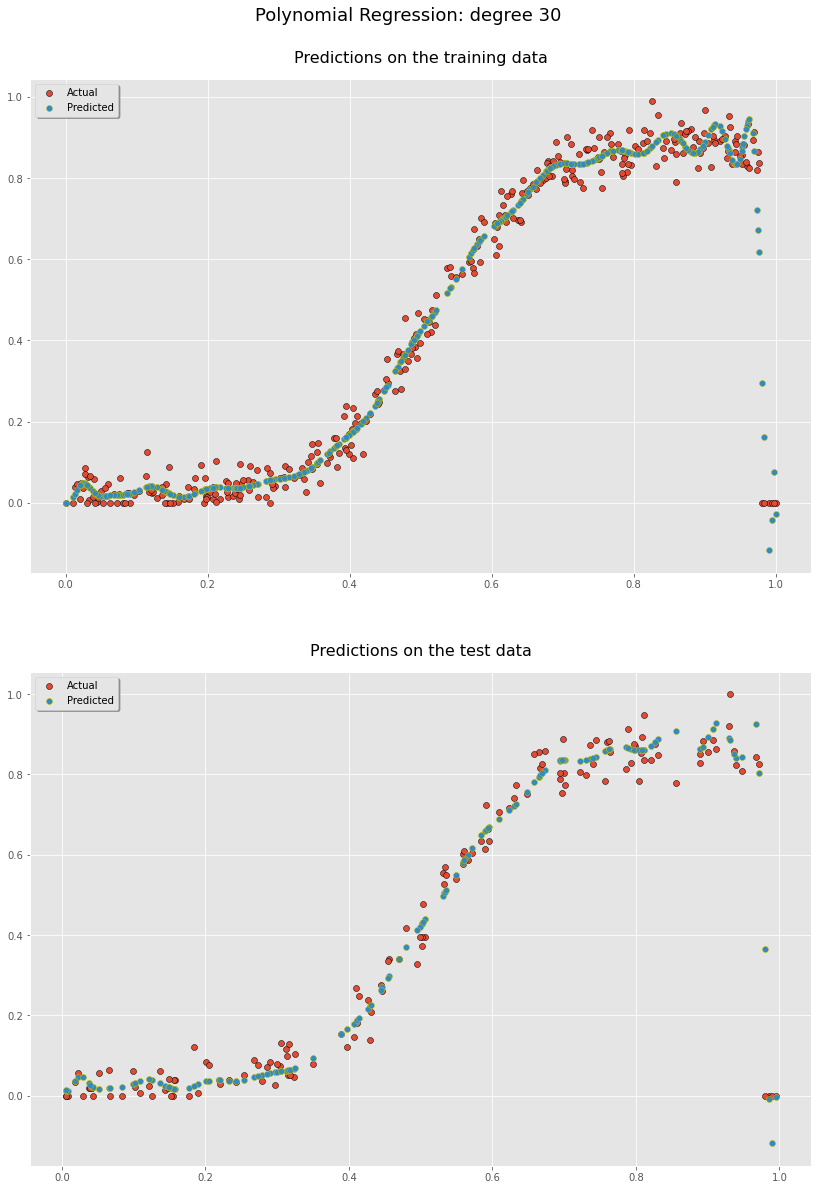

In [22]:
# Plot the actual and predicted data for plynomial regression.
plot(y_train_poly, y_test_poly, f"Polynomial Regression: degree {n}")

<br>

The predicted data appears to be well-fitting to the actual data. However, it does predict negative values like the simple linear regression did. In contrast to the previous model it does reflect the downward trend.

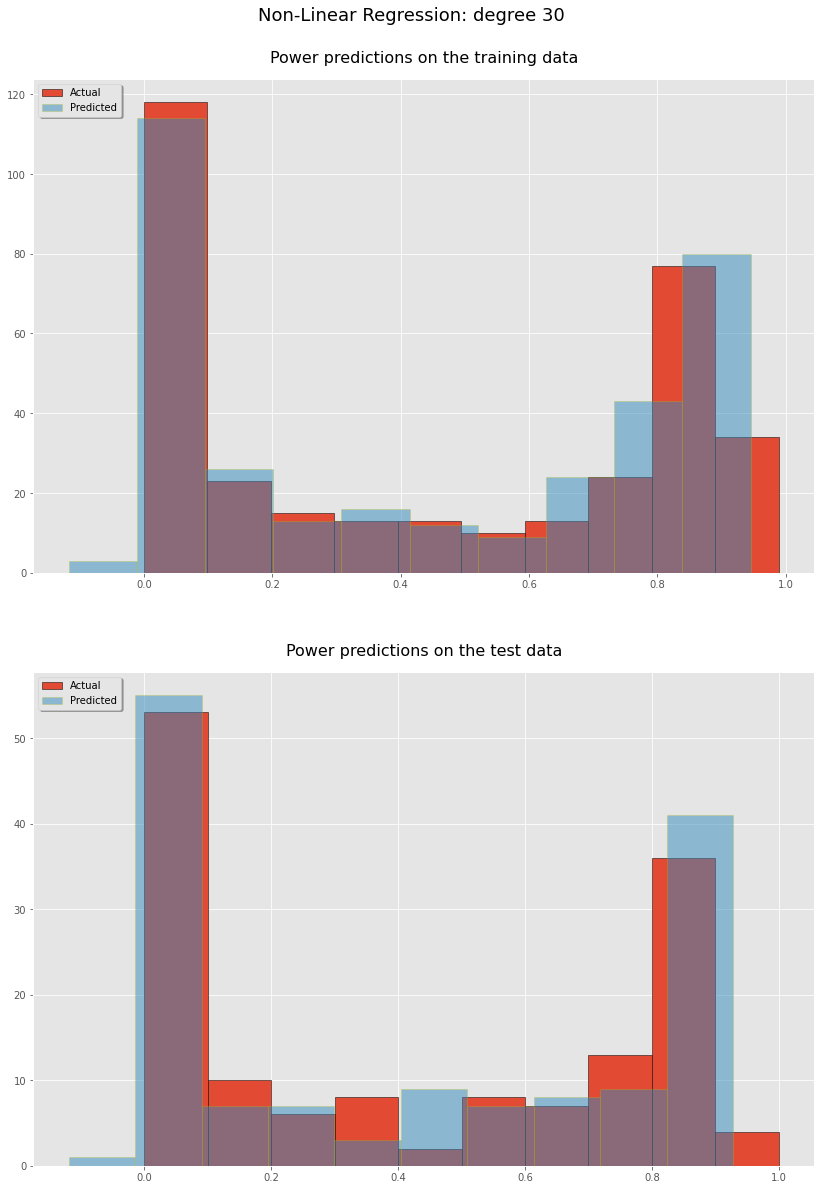

In [23]:
# Comparing power distribution for polynomial regression.
hist(y_train_poly, y_test_poly, f"Non-Linear Regression: degree {n}")

The negative predictions aside, the predicted distribution follows the actual distribution quite closely.

<br>

In [24]:
# Comparison of the predictions and actual data for the simple linear regression.
comparison(polynomial, y_train_poly, y_test_poly)

TRAINING DATA
Actual power:	 4.443
Predicted power: 6.949

TEST DATA
Actual power:	 91.125
Predicted power: 94.927

WITHOUT THE CONSTRAINT
Predicted power for wind speed 0: -0.042
Predicted power for wind speed 30: -111722648375857676383431856378491421225126991223876057888194560.000
Predicted power for wind speed 70: -16253678063179798124301362541023530005011091191906653046298842378862067712.000

WITH THE CONSTRAINT
Predicted power for wind speed 0: 0.0
Predicted power for wind speed 30: 0.0
Predicted power for wind speed 70: 0.0


In these results, the predictions are much closer to the actual power output than with the previous model. The model also indicates a tendency for an overestimation of the training and test power for the chosen samples but to a much lower degree.

In the power outputs for 0 m/s, 3 0m/s and 70 m/s wind speed, the model predicts a nearly correct 0.0 output for 0 m/s, but for 30 m/s and 70 m/s the predictions are extreme negative values. Therefore, in this model only one contraint for removing negative values was applied.

<br> 

_Evaluation_

In [25]:
# Calculate RMSE and R-squared score for the polynomial regression.
train(y_train_poly)
test(y_test_poly)

TRAINING DATA
RMSE: 		 0.0440248998984183
R-squared Score: 0.985633985178214

TEST DATA
RMSE: 		 0.050432835878573154
R-squared Score: 0.9803484897985708


The result of computing the metrics confirms a high accuracy of the model.

<br>

### Build, Predict, and Evaluate the Models with SciPy <a name="scipy"></a>
___

> [10] [Polynomial Regression — which python package to use?](https://towardsdatascience.com/polynomial-regression-which-python-package-to-use-78a09b0ac87b)

In [26]:
# Linear function.
def linear_function(x, a, b):
    return a * x + b

# Fit the model.
linear_s = curve_fit(linear_function, speed_train, power_train)[0]

# Predict power output with simple linear regresiion
y_pred_train_linear = linear_function(speed_train, linear_s[0], linear_s[1])
y_pred_test_linear = linear_function(speed_test, linear_s[0], linear_s[1])

In [27]:
def poly_model(degree):
    poly_model = odr.polynomial(degree)
    data = odr.Data(speed_train, power_train)
    odr_obj = odr.ODR(data, poly_model)

    # Running ODR fitting
    output = odr_obj.run() 
    poly = np.poly1d(output.beta[::-1])
    return poly

In [28]:
# NOTE: the code takes a long time to run!
""" Find the best degree for polynomial regression.
degrees = []

for degree in range(0, 150):
    # Build polynomial regression using scipy 

    # Predict power output with polynomial regression 
    y_pred_test_polynomial = poly(speed_test)
    # Append score.
    degrees.append((degree, r_2(power_test,y_pred_test_polynomial), rmse(power_test,y_pred_test_polynomial)))

# Sort scores in the reverse order by the score. 
degrees.sort(key=lambda x:float(x[1]), reverse=True)

# Return only the first 5 results.
for j in degrees[:5]:
    # Print results.
    print(f'{j}')
"""

" Find the best degree for polynomial regression.\ndegrees = []\n\nfor degree in range(0, 150):\n    # Build polynomial regression using scipy \n\n    # Predict power output with polynomial regression \n    y_pred_test_polynomial = poly(speed_test)\n    # Append score.\n    degrees.append((degree, r_2(power_test,y_pred_test_polynomial), rmse(power_test,y_pred_test_polynomial)))\n\n# Sort scores in the reverse order by the score. \ndegrees.sort(key=lambda x:float(x[1]), reverse=True)\n\n# Return only the first 5 results.\nfor j in degrees[:5]:\n    # Print results.\n    print(f'{j}')\n"

The best R-squared score and the lowest RMSE are with 117 degrees.

In [29]:
# Build polynomial regression with degree 117
degree = 117
poly = poly_model(degree)

# Predict power output with polynomial regression 
y_pred_train_polynomial = poly(speed_train)
y_pred_test_polynomial = poly(speed_test)

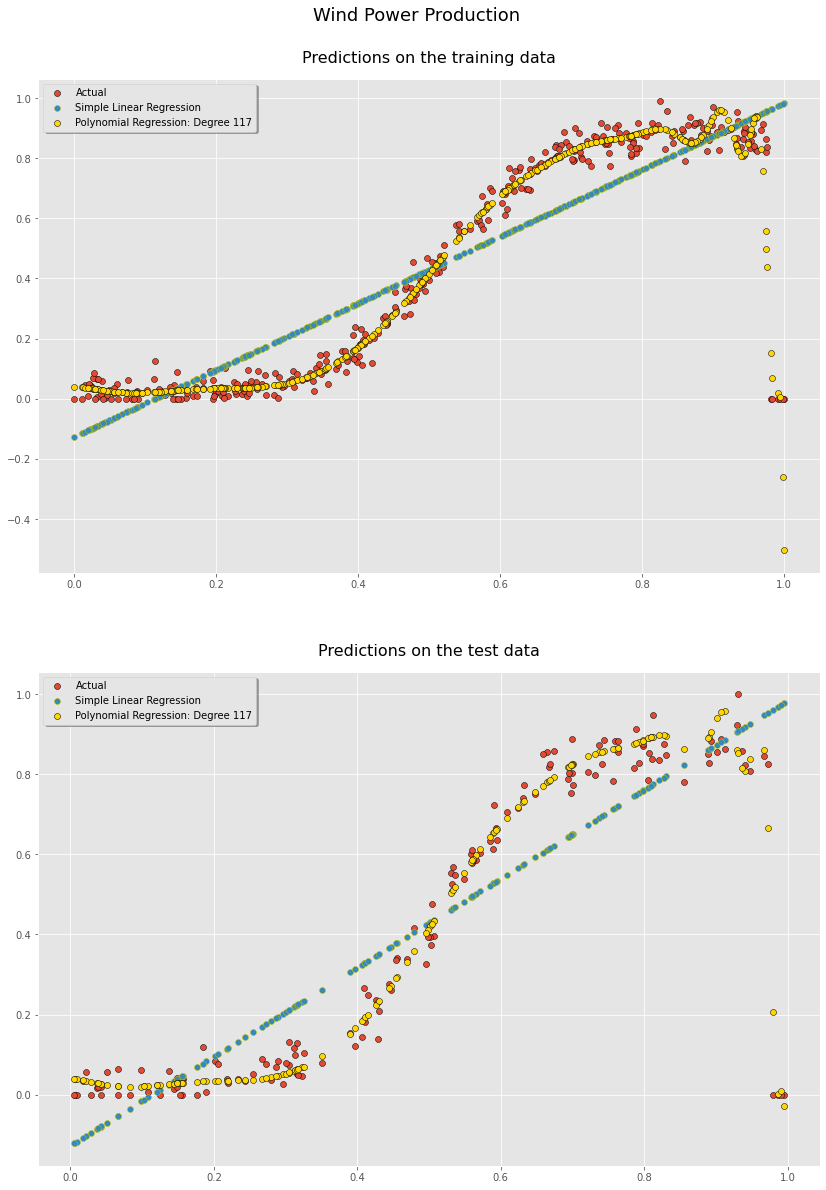

In [30]:
# Create a figure, axis and titles.
fig, [ax1,ax2] = plt.subplots(2,1, figsize=(14,20))
fig.suptitle("Wind Power Production", y = 0.93)
ax1.set_title("Predictions on the training data",y=1.02, fontsize=16)
ax2.set_title("Predictions on the test data",y=1.02, fontsize=16)

# Plot the actual training data and predictions.
ax1.scatter(speed_train, power_train, edgecolor="black",  label="Actual")
ax1.scatter(speed_train, y_pred_train_linear, edgecolor="y", label="Simple Linear Regression")
ax1.scatter(speed_train, y_pred_train_polynomial, c="gold", edgecolor="black", label=f"Polynomial Regression: Degree {degree}")

# Plot the actual test data and predictions.
ax2.scatter(speed_test, power_test, edgecolor="black",  label="Actual")
ax2.scatter(speed_test, y_pred_test_linear, edgecolor="y", label="Simple Linear Regression")
ax2.scatter(speed_test, y_pred_test_polynomial, c="gold", edgecolor="black", label=f"Polynomial Regression: Degree {degree}")

# Show the legend.
ax1.legend(loc='upper left', shadow=True)
ax2.legend(loc='upper left', shadow=True)

# Show the plot.
plt.show()

In [31]:
print("\nSIMPLE LINEAR REGRESSION")
train(y_pred_train_linear)
test(y_pred_test_linear)

print("\nPOLYNOMIAL REGRESSION")
train(y_pred_train_polynomial)
test(y_pred_test_polynomial)


SIMPLE LINEAR REGRESSION
TRAINING DATA
RMSE: 		 0.17499621284165545
R-squared Score: 0.7730151580555515

TEST DATA
RMSE: 		 0.19666060418559445
R-squared Score: 0.6991996513082248

POLYNOMIAL REGRESSION
TRAINING DATA
RMSE: 		 0.060018702410958205
R-squared Score: 0.9737230288337984

TEST DATA
RMSE: 		 0.04704555455381886
R-squared Score: 0.982904929159726


<br>

### Conclusion.

___

In this notebook, I have built three models, Poisson Regression with Polynomial Features, Decision Tree and Neural Network, to make predictions of wind turbine power output for provided wind speed. The model performance evaluation determined that the best results are produced by the Neural Network model, although this model was the slowest to train.

___

<br>

### End.